In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
import seaborn as sns


from scipy.stats import zscore

from numpy.random import multivariate_normal
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"

# Load data and Gaussian mixture model

In [2]:
with open('{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
# with open('../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl', 'rb') as f:
#     segments_errors = pickle.load(f)
# with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
#     id_per_seg = pickle.load(f)

weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])

with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)
    
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature


desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
# desc_stats[:,0] = np.median(segments_counts, axis=1).flatten()
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# desc_GM = np.hstack((zscore(desc_stats, axis=0), GMM_bics))

shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [3]:
with open('{}/GMM_shape16_moments4_components500_alldata.pkl'.format(data_dir), 'rb') as f: # 500 component Gausssian mixture model fit to the 468202 20d samples
    clf_GM500 = pickle.load(f)

In [ ]:
with open('{}/shape_moments_GM500_labels.pkl'.format(data_dir), 'rb') as f: # 500 component Gausssian mixture model fit to the 468202 20d samples
    shape_moments_GM500_labels = pickle.load(f)

In [ ]:
with open('{}/shape_moments_GM500_proba.pkl'.format(data_dir), 'rb') as f: # 500 component Gausssian mixture model fit to the 468202 20d samples
    shape_moments_GM500_proba = pickle.load(f)

In [64]:
with open("{}/reconstructions_from_model_2020-04-29_09-12-23.pkl".format(data_dir), 'rb') as f: # output of LSTM autoencoder's decoder
    segment_reconstructions = pickle.load(f)

In [4]:
# shape_moments_GM500_labels = clf_GM500.predict(shape_moments)
# with open('{}/shape_moments_GM500_labels.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(shape_moments_GM500_labels, f)

In [5]:
# shape_moments_GM500_proba = clf_GM500.predict_proba(shape_moments)
# with open('{}/shape_moments_GM500_proba.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(shape_moments_GM500_proba, f)

# Merge Gaussian Components

In [8]:
def calculate_entropy(probs, comps):
    """
    probs : array of data point probability under the components of the mixture model (output of predict_proba method), shape (n_observations, n_components)
    comps : list of indices of components whose entropy is to be calculated
    """
    return -np.nansum(probs.T[comps]*np.log10(probs.T[comps]))

def calculate_information_gain(probs, comps):
    """
    probs : array of data point probability under the components of the mixture model (output of predict_proba method), shape (n_observations, n_components)
    comps : two indicies of components within probs whose merger entropy difference is to be calculated
    """
    np.seterr(all = 'ignore') # ignore divide by zero coming from tiny probability values
    seperate_ent = calculate_entropy(probs, comps)
    merged_prob = probs.T[comps[0]]+probs.T[comps[1]]
    merged_ent = -np.nansum(merged_prob*np.log10(merged_prob))
    np.seterr(all = 'warn') 
    return seperate_ent-merged_ent

def entropy_Gaussian_component_clustering(init_probability, data_classification, normalize_info_gain = True):
    """
        Inputs :
    init_probability : float numpy array of data point probability under the components of the mixture model (output of predict_proba method), with shape 
                        [n_observations, n_components]
    data_classification : interger numpy array of indices that correspond to the Gaussian component assignment (output of predict method), with size [n_observations]
    normalize_info_gain : True if information gain values calculated for possible merge pairs are to be divided by the number of data points involved. When False, the order 
                            of mergers tends to be biased towards components with large populations.  
                            
        Returns :
    information_gain : dense matrix with shape [2*n_components-1, 2*n_components-1], containing difference in entropy caused by the merger of Gaussian mixture components
                        (columns and rows up to n_components), and by the composit clusters (columns and rows beyond n_components). Only the upper triangle is utilised.
                        Float -2.0 is placed in unused positions, Float -1.0 is placed in positions that require calculation.
    merger_history : list of pairs of indices of components/clusters in the order of merging, size [n_components-1]
    """
    # probability of data under the original 114 components, and under merged components
    probs = np.hstack((init_probability, np.zeros((init_probability.shape[0], init_probability.shape[1]-1)))) # (468202, 227) for 114 components
    # information gain from the merger of each pair of components
    # only positions with -1 will need to be calculated (upper triangle of the symmetric matrix)
    len_info_gains = 2*init_probability.shape[1]-1
    info_gains = np.ones((len_info_gains,len_info_gains))*-1 
    info_gains[np.tril_indices(len_info_gains, k=0, m=None)[0], np.tril_indices(len_info_gains, k=0, m=None)[1]] = -2. #-2 will be skipped
    
    if  normalize_info_gain == True:
        #number of data points involved in the mergers
        no_datapoints_components = np.unique(data_classification, return_counts=1)[1]
        no_datapoints = np.hstack((no_datapoints_components, np.zeros(init_probability.shape[1]-1))) # components nad composite clusters

    # for keeping track of indices of components that can still be merged
    current_comps = list(range(init_probability.shape[1])) 
    merger_history = [] # indices of merged clusters
    
    for merger_ind in range(init_probability.shape[1]-1):
        merger_ind += init_probability.shape[1] # this will be the index of next merged cluster's column within probability array "probs"
        
        if normalize_info_gain == True:
            for k1 in current_comps:
                for k2 in current_comps: # calculations proceed in rows
                    if k1 == k2: continue # skip mergers with self
                    if not info_gains[k1,k2] == -1.: continue # only evaluate for -1 (place-holder values)

                    info_gains[k1,k2] = calculate_information_gain(probs, [k1,k2]) / np.sum((no_datapoints[k1],no_datapoints[k2]))
        else:
            for k1 in current_comps:
                for k2 in current_comps: # calculations proceed in rows
                    if k1 == k2: continue # skip mergers with self
                    if not info_gains[k1,k2] == -1.: continue # only evaluate for -1 (place-holder values)

                    info_gains[k1,k2] = calculate_information_gain(probs, [k1,k2])

        # select the pair of currently available component indices that produces the highest gain value
        sorted_gains = np.argsort(info_gains.flatten())[::-1]# descending list of indices of sorted gain values
        max_gain_pos = np.unravel_index(sorted_gains[0], info_gains.shape)#  
        gain_val_rank = 0
        while (max_gain_pos[0] not in current_comps) or (max_gain_pos[1] not in current_comps):# find top info gain value for existing components
            gain_val_rank+=1
            max_gain_pos = np.unravel_index(sorted_gains[gain_val_rank], info_gains.shape)#(np.where(sorted_gains[gain_val_rank] ==info_gains)[0][0], np.where(sorted_gains[gain_val_rank] ==info_gains)[1][0])#np.unravel_index(sorted_gains[int(gain_val_rank)], info_gains.shape)

        probs[:, merger_ind] = probs[:, max_gain_pos[0]]+probs[:, max_gain_pos[1]] # calculate data probability for the merged component
        merger_history.append(max_gain_pos) # save component indices for this merger 
        if normalize_info_gain == True:
            no_datapoints[merger_ind] = np.sum((no_datapoints[max_gain_pos[0]], no_datapoints[max_gain_pos[1]])) # record the number of data points in the new cluster

        #remove indices of the merged components from the list and add the component's index
        current_comps.remove(max_gain_pos[0])
        current_comps.remove(max_gain_pos[1])
        current_comps.append(merger_ind)


        print(merger_ind-init_probability.shape[1], "/{} mergers performed".format(init_probability.shape[1]))
        clear_output(wait=1)
        
    print("Finished.")
    return info_gains, merger_history

In [9]:
info_gains, merger_history = entropy_Gaussian_component_clustering(shape_moments_GM500_proba, shape_moments_GM500_labels, normalize_info_gain = True)

0 /500 mergers performed
1 /500 mergers performed
2 /500 mergers performed
3 /500 mergers performed
4 /500 mergers performed
5 /500 mergers performed
6 /500 mergers performed
7 /500 mergers performed
8 /500 mergers performed
9 /500 mergers performed
10 /500 mergers performed
11 /500 mergers performed
12 /500 mergers performed
13 /500 mergers performed
14 /500 mergers performed
15 /500 mergers performed
16 /500 mergers performed
17 /500 mergers performed
18 /500 mergers performed
19 /500 mergers performed
20 /500 mergers performed
21 /500 mergers performed
22 /500 mergers performed
23 /500 mergers performed
24 /500 mergers performed
25 /500 mergers performed
26 /500 mergers performed
27 /500 mergers performed
28 /500 mergers performed
29 /500 mergers performed
30 /500 mergers performed
31 /500 mergers performed
32 /500 mergers performed
33 /500 mergers performed
34 /500 mergers performed
35 /500 mergers performed
36 /500 mergers performed
37 /500 mergers performed
38 /500 mergers perfor

[  1.           7.42556283  53.23466876 123.43259976 226.54217743
 431.32259018 499.        ]


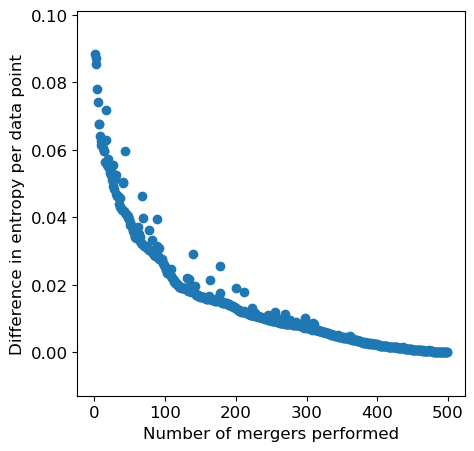

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf
plt.close()

plt.rcParams['figure.figsize'] = (5.0, 5.0)


chrono_gains = [info_gains[x,y] for x,y in merger_history]


x = np.array(list(range(len(merger_history))), dtype=float)+1
y = np.array(chrono_gains)

# my_pwlf = pwlf.PiecewiseLinFit(x, y)
# breaks = my_pwlf.fit(6)
print(breaks)

# x_hat = np.linspace(x.min(), x.max(), 100)
# y_hat = my_pwlf.predict(x_hat)

plt.figure()
plt.scatter(x, y)#, c=point_colors)
# plt.plot(x_hat, y_hat, '-')
plt.ylabel("Difference in entropy per data point")
plt.xlabel("Number of mergers performed")
# plt.text(x=60, y=0.08, s="breakpoints: "+str([str(break1)[:5] for break1 in breaks[1:3]]))

plt.show()

In [53]:
point_colors = ["blue"]*len(chrono_gains)
for n_point, point in enumerate(chrono_gains[100:-1]):
    if (point> np.array(chrono_gains[98+n_point:100+n_point])*1.15).all() and (point> np.array(chrono_gains[101+n_point:103+n_point])*1.15).all():
        point_colors[100+n_point] = "red"

In [56]:
np.where(np.array(point_colors)=="red")

(array([130, 133, 138, 162, 177, 199, 211, 222, 255, 269, 361, 472]),)

In [12]:
# make a 468202 list of classifications for the new clusters

import copy

no_comps =500

starting_components = list(range(no_comps)) 
merger_state = dict(("merger "+str(merger_no), dict()) for merger_no in list(range(no_comps)))
merger_state["merger 0"]=dict(("cluster "+str(component),[component]) for component in starting_components)
for merger_no, merger_comps in enumerate(merger_history):
    merger_state["merger "+str(merger_no+1)] = copy.deepcopy(merger_state["merger "+str(merger_no)])
    merged_components = copy.deepcopy([merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[0])], merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[1])]])
    del merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[0])]
    del merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[1])]
    merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_no+no_comps)] = [item for sublist in merged_components for item in sublist]

component_datapoints = np.zeros(no_comps+len(merger_history))
component_datapoints[:no_comps] = np.unique(shape_moments_GM500_labels, return_counts=1)[1]

for merger_ind, merger in enumerate(merger_history):
    merger_ind+=no_comps
    component_datapoints[merger_ind] = component_datapoints[merger[0]]+component_datapoints[merger[1]]

for merger_key,merger_vals in merger_state.items():
    # count number of components that make up each cluster, then find how common the counts are
    no_unique_component_counts = np.unique([len(comp_vals) for comp_key, comp_vals in merger_vals.items()], return_counts=True) 
    comps_involved = [int(cluster_str[8:]) for cluster_str in merger_vals.keys()]
    print(merger_key,"\tnumber of clusters: ", len(merger_vals),"\t sizes of clusters, number of each size of cluster", no_unique_component_counts, "\tmax cluster size: ",
          np.max([component_datapoints[comp_ind] for comp_ind in comps_involved]))



merger 0 	number of clusters:  500 	 sizes of clusters, number of each size of cluster (array([1]), array([500])) 	max cluster size:  10192.0
merger 1 	number of clusters:  499 	 sizes of clusters, number of each size of cluster (array([1, 2]), array([498,   1])) 	max cluster size:  10192.0
merger 2 	number of clusters:  498 	 sizes of clusters, number of each size of cluster (array([1, 3]), array([497,   1])) 	max cluster size:  11514.0
merger 3 	number of clusters:  497 	 sizes of clusters, number of each size of cluster (array([1, 2, 3]), array([495,   1,   1])) 	max cluster size:  11514.0
merger 4 	number of clusters:  496 	 sizes of clusters, number of each size of cluster (array([1, 2, 3]), array([493,   2,   1])) 	max cluster size:  11514.0
merger 5 	number of clusters:  495 	 sizes of clusters, number of each size of cluster (array([1, 2, 3]), array([491,   3,   1])) 	max cluster size:  11514.0
merger 6 	number of clusters:  494 	 sizes of clusters, number of each size of clust

In [184]:
merger_history[347:]

[(821, 823),
 (824, 836),
 (88, 159),
 (93, 316),
 (447, 846),
 (126, 728),
 (685, 762),
 (231, 757),
 (803, 854),
 (730, 753),
 (436, 814),
 (341, 778),
 (200, 225),
 (217, 751),
 (853, 860),
 (849, 851),
 (847, 862),
 (387, 784),
 (690, 864),
 (292, 498),
 (80, 243),
 (42, 485),
 (766, 855),
 (100, 826),
 (399, 429),
 (844, 861),
 (755, 856),
 (479, 827),
 (841, 869),
 (320, 476),
 (319, 835),
 (623, 852),
 (260, 761),
 (764, 870),
 (865, 880),
 (50, 116),
 (308, 466),
 (792, 818),
 (831, 884),
 (729, 829),
 (146, 857),
 (333, 425),
 (845, 878),
 (619, 889),
 (157, 874),
 (384, 409),
 (3, 825),
 (349, 712),
 (866, 891),
 (863, 893),
 (175, 708),
 (345, 879),
 (18, 822),
 (221, 304),
 (895, 900),
 (848, 901),
 (723, 830),
 (219, 859),
 (180, 858),
 (832, 896),
 (262, 843),
 (79, 892),
 (898, 907),
 (873, 877),
 (791, 850),
 (134, 899),
 (357, 872),
 (650, 890),
 (881, 885),
 (834, 910),
 (904, 908),
 (361, 432),
 (840, 883),
 (41, 350),
 (906, 911),
 (366, 383),
 (208, 328),
 (418, 88

In [67]:
cluster_of_interest = merger_state["merger 347"]#['cluster 847']
print(len(cluster_of_interest))
cluster_of_interest

153


{'cluster 3': [3],
 'cluster 9': [9],
 'cluster 12': [12],
 'cluster 18': [18],
 'cluster 37': [37],
 'cluster 41': [41],
 'cluster 42': [42],
 'cluster 50': [50],
 'cluster 63': [63],
 'cluster 78': [78],
 'cluster 79': [79],
 'cluster 80': [80],
 'cluster 84': [84],
 'cluster 88': [88],
 'cluster 93': [93],
 'cluster 94': [94],
 'cluster 100': [100],
 'cluster 108': [108],
 'cluster 116': [116],
 'cluster 119': [119],
 'cluster 126': [126],
 'cluster 134': [134],
 'cluster 143': [143],
 'cluster 146': [146],
 'cluster 153': [153],
 'cluster 154': [154],
 'cluster 157': [157],
 'cluster 159': [159],
 'cluster 175': [175],
 'cluster 180': [180],
 'cluster 184': [184],
 'cluster 191': [191],
 'cluster 200': [200],
 'cluster 201': [201],
 'cluster 208': [208],
 'cluster 210': [210],
 'cluster 217': [217],
 'cluster 219': [219],
 'cluster 220': [220],
 'cluster 221': [221],
 'cluster 225': [225],
 'cluster 231': [231],
 'cluster 243': [243],
 'cluster 250': [250],
 'cluster 260': [260],
 

In [177]:
small_clusters = []
for k,v in merger_state["merger 347"].items():
    if len(v)< 10:
        small_clusters.append(v)


In [179]:
len(small_clusters)

147

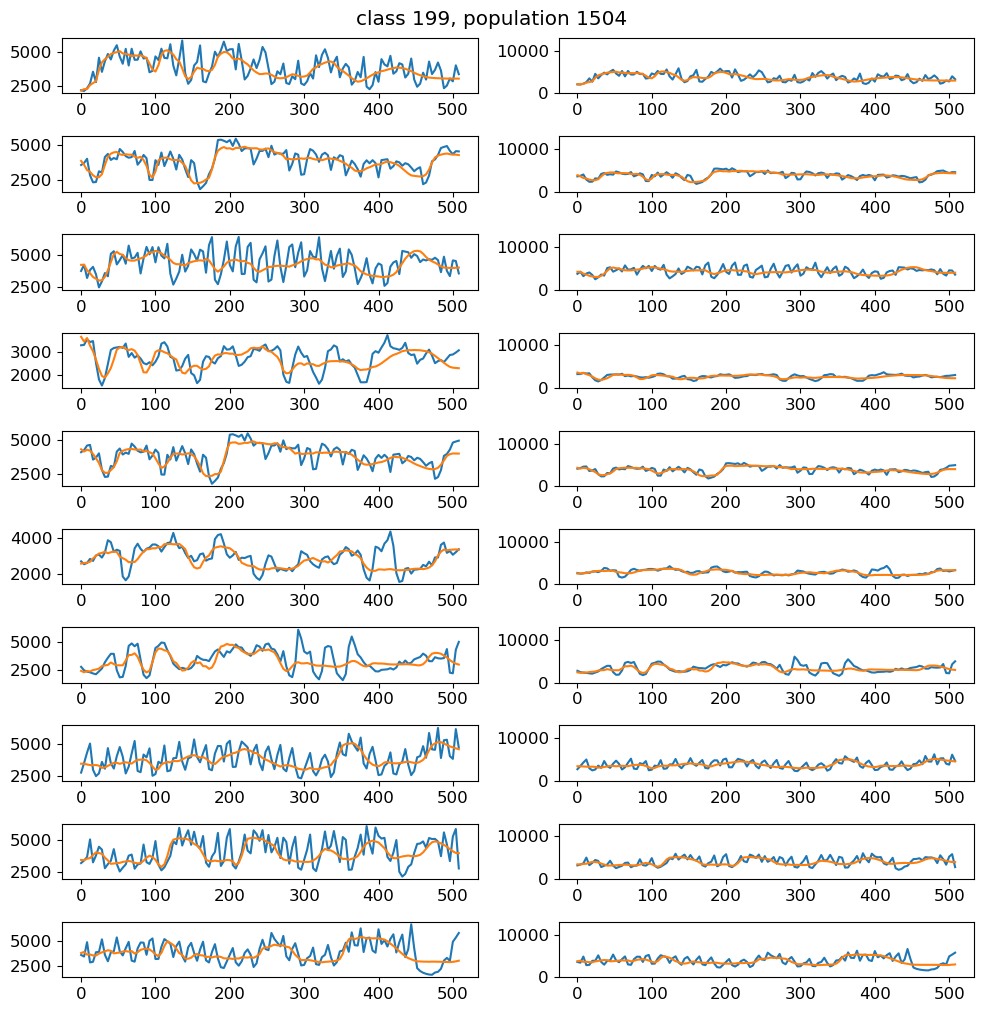

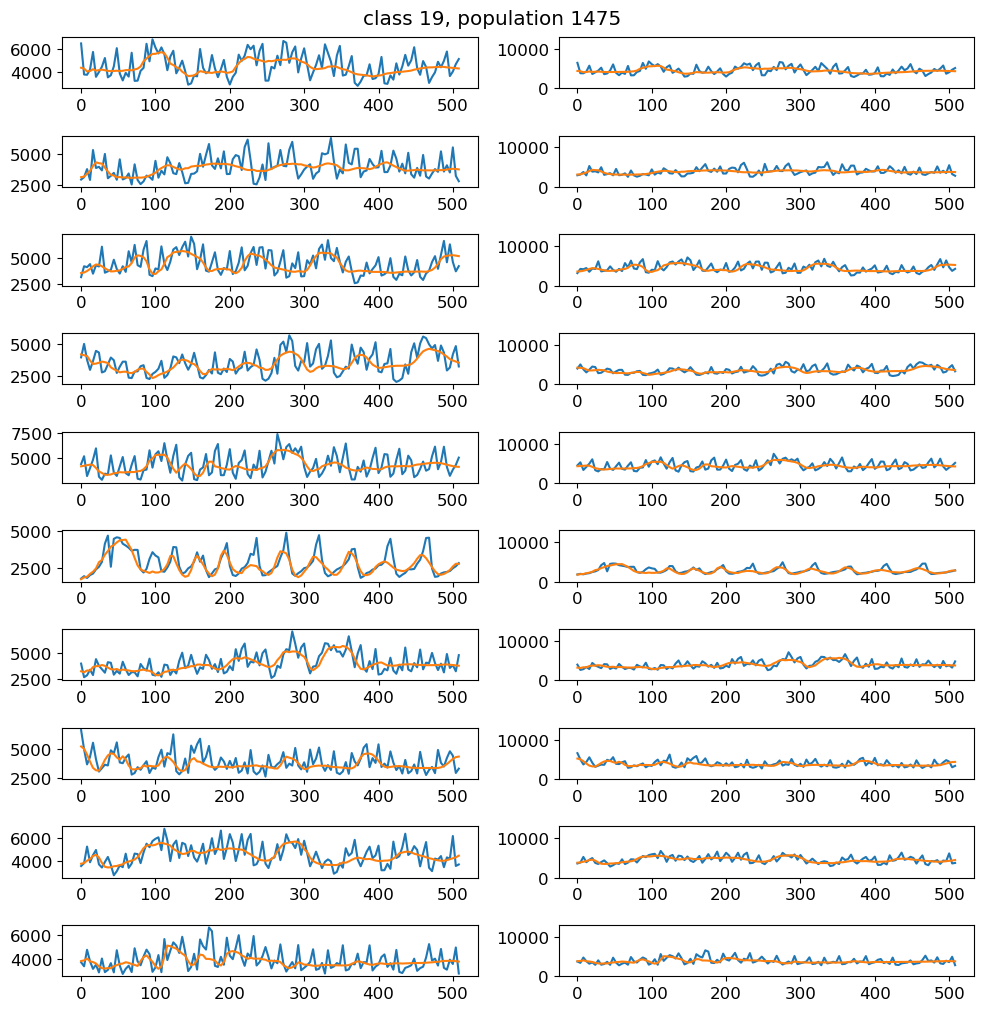

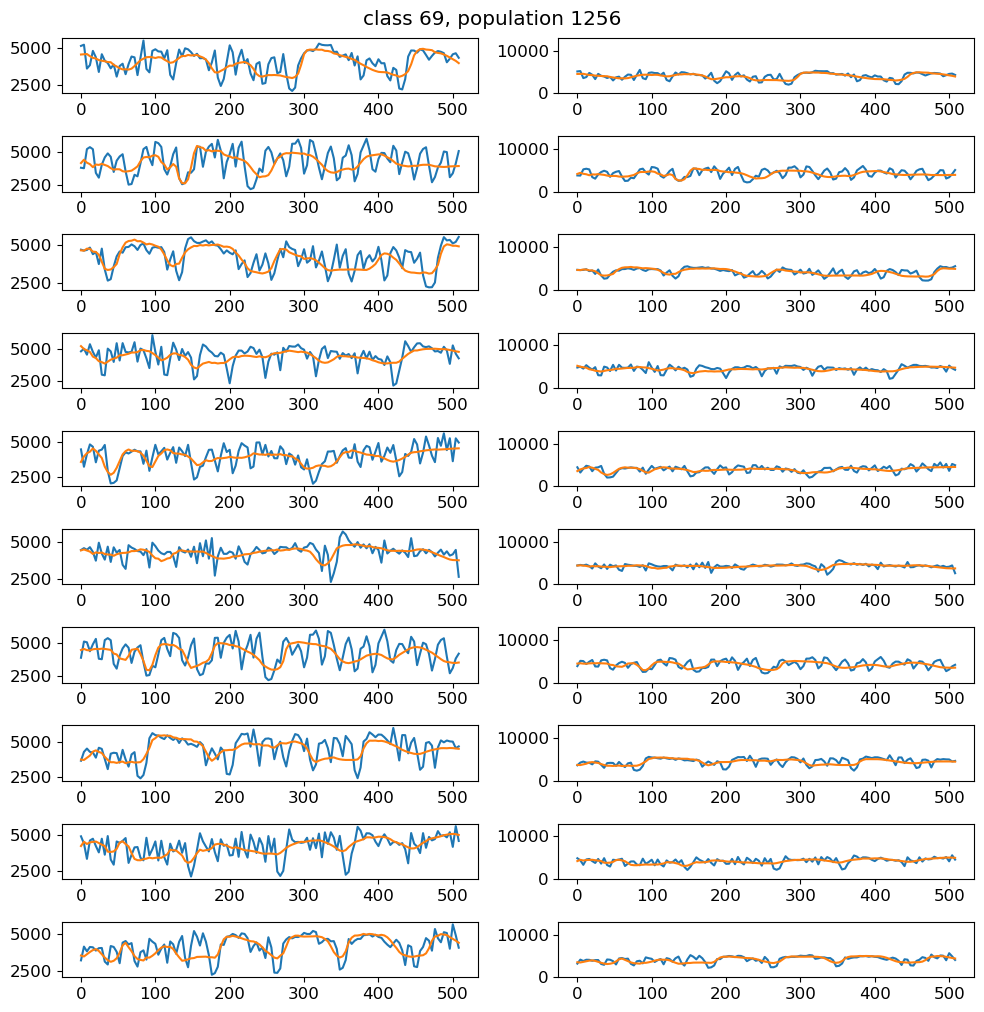

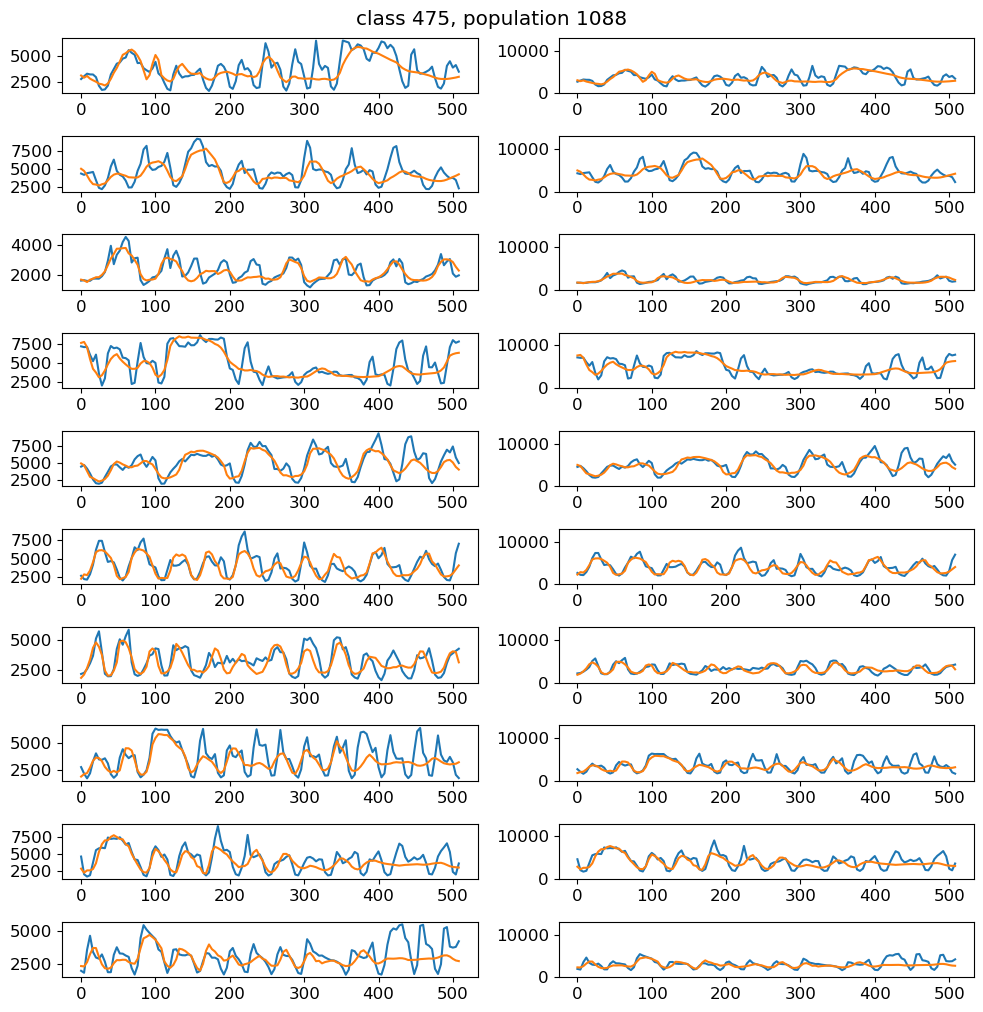

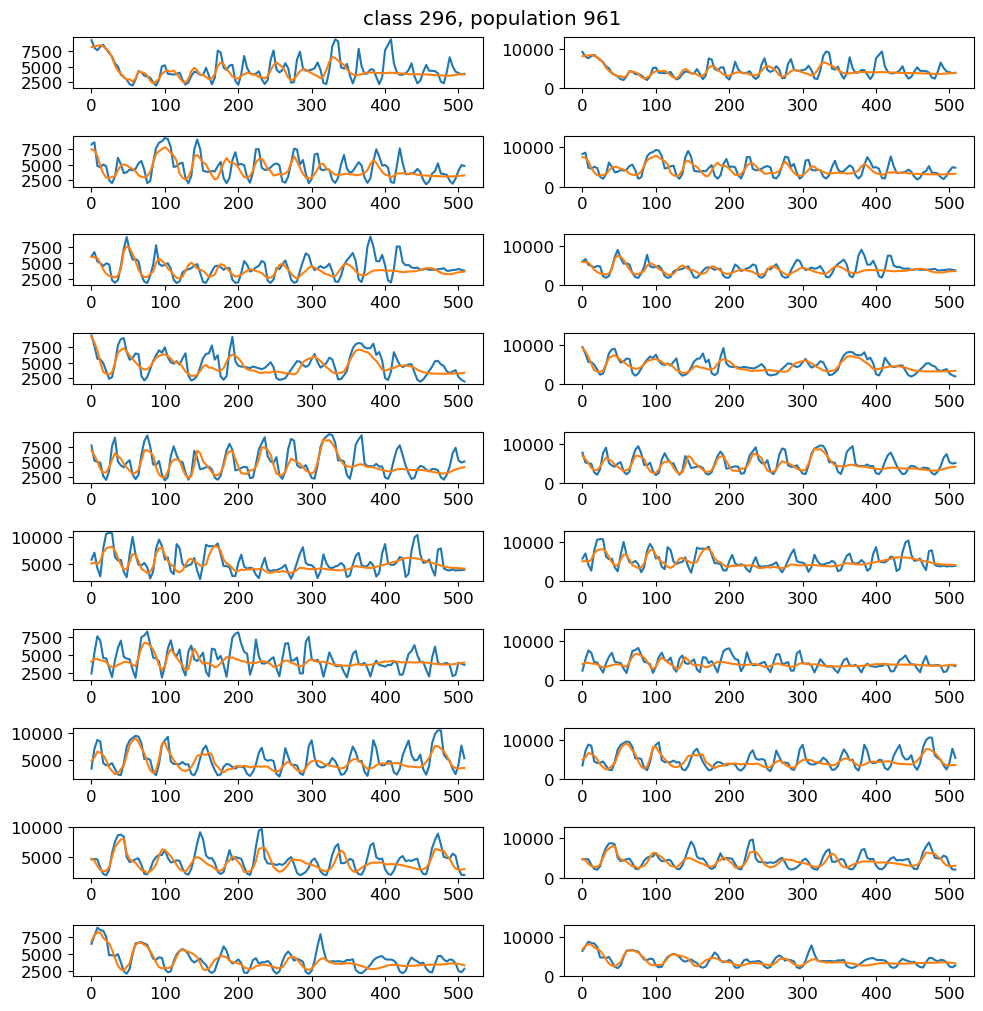

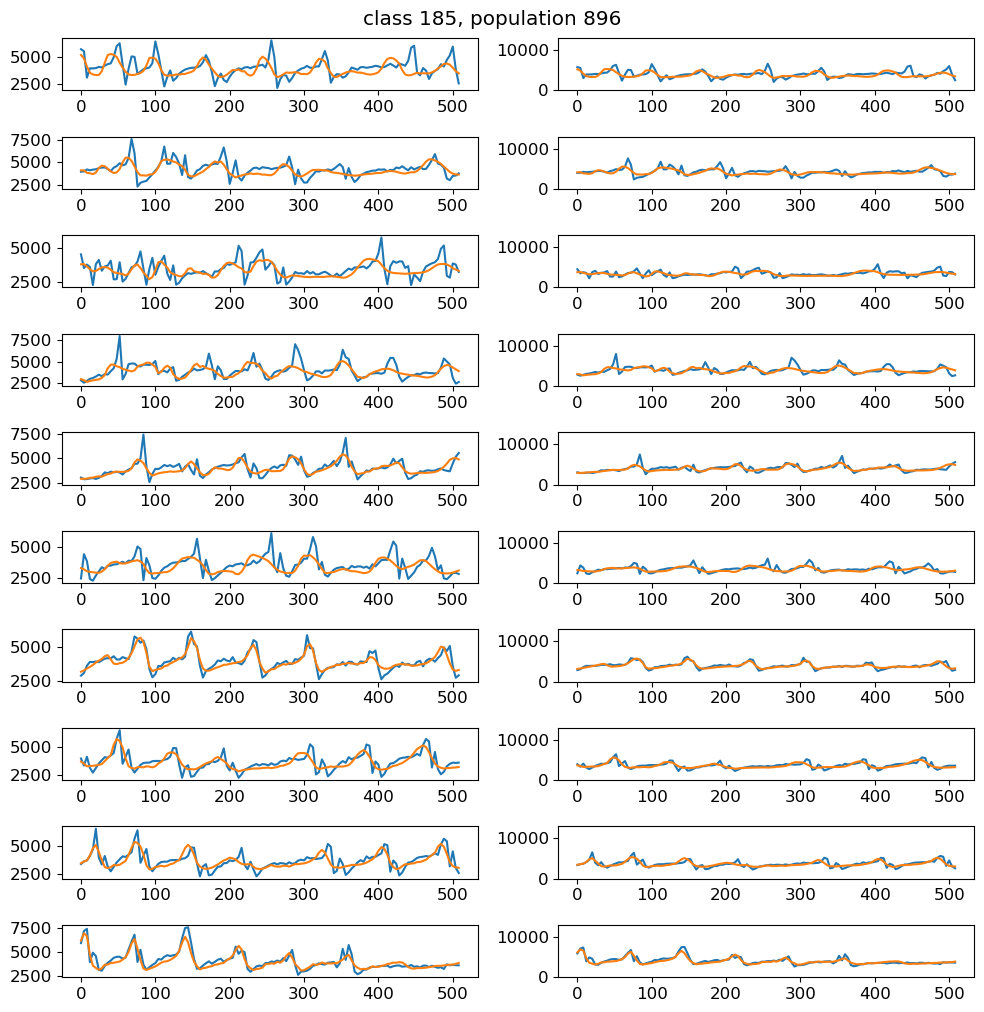

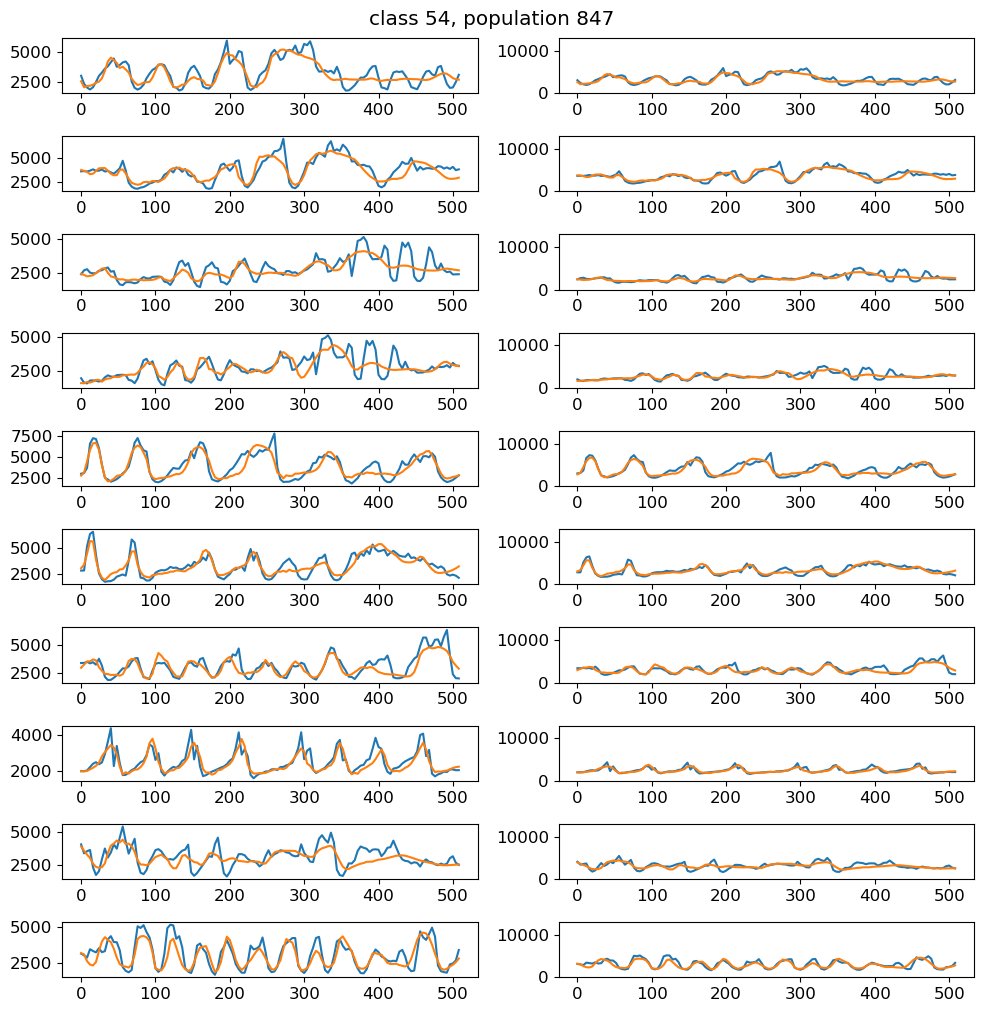

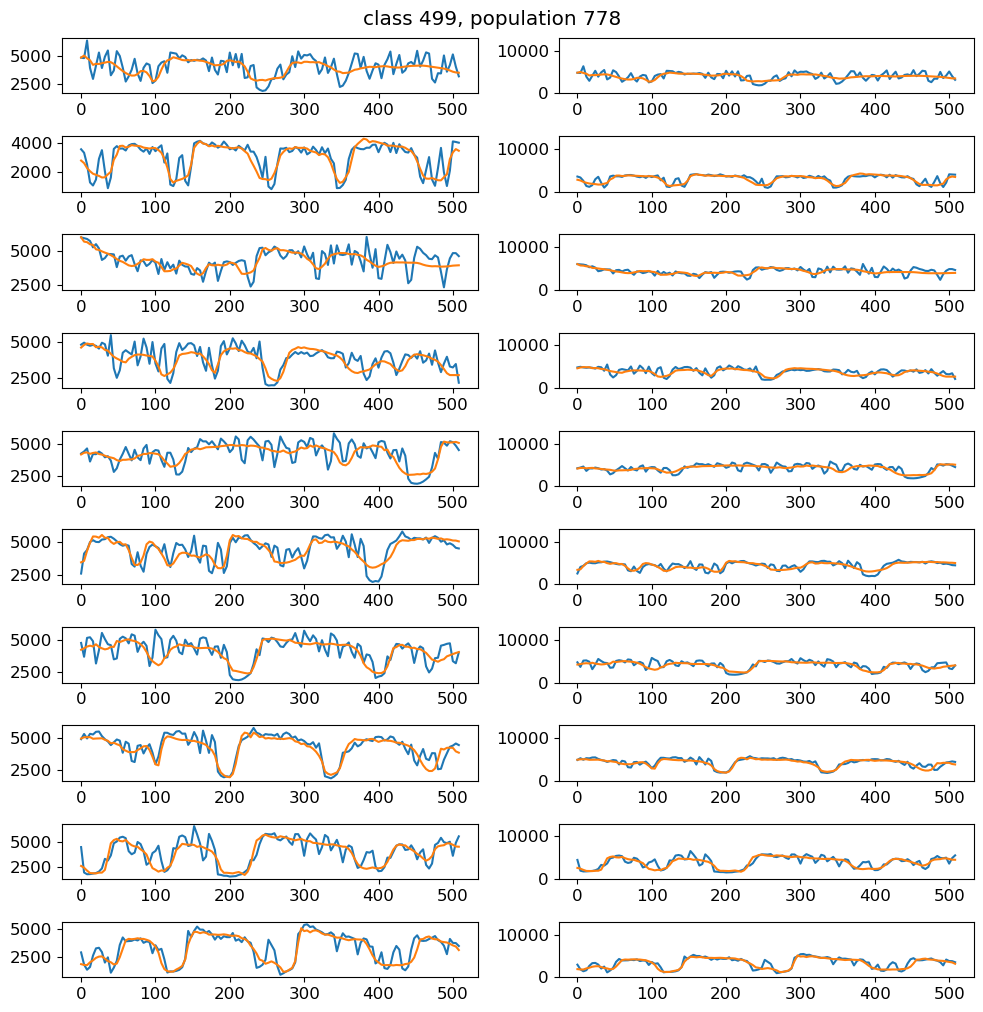

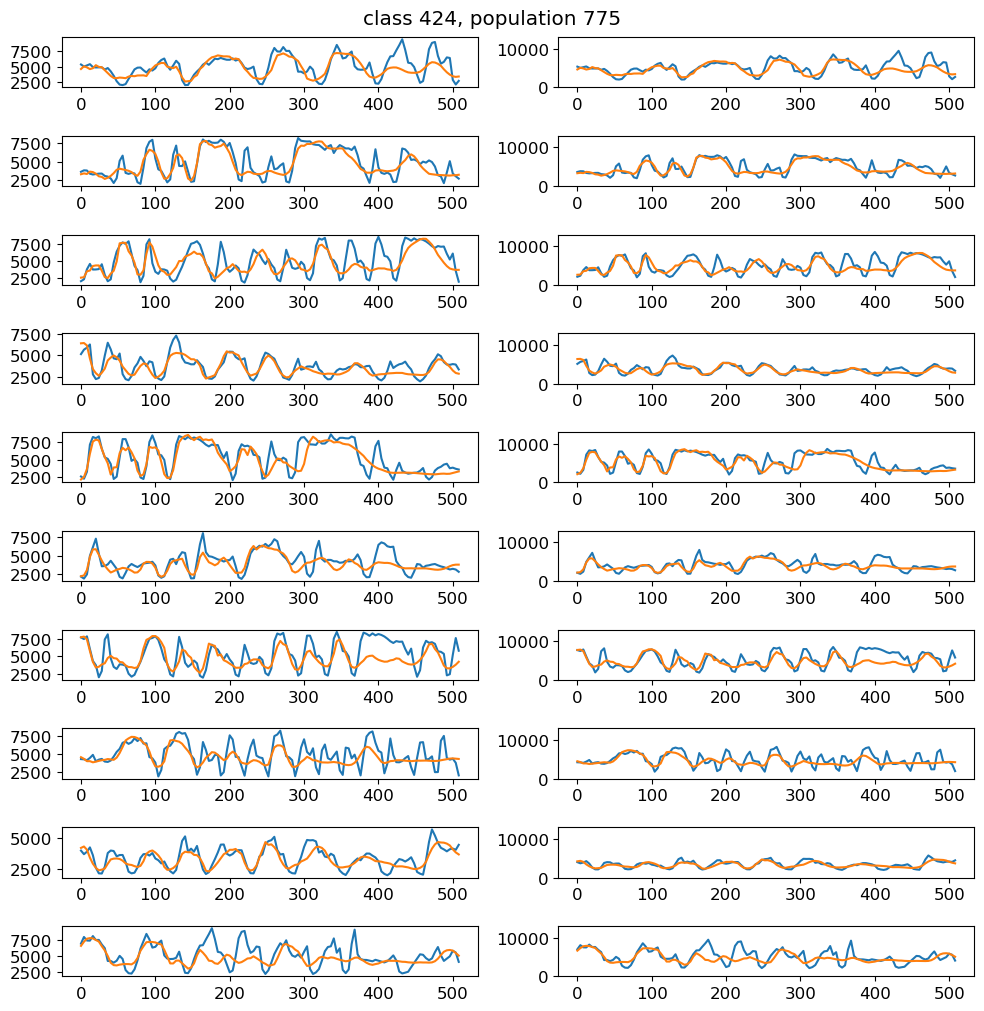

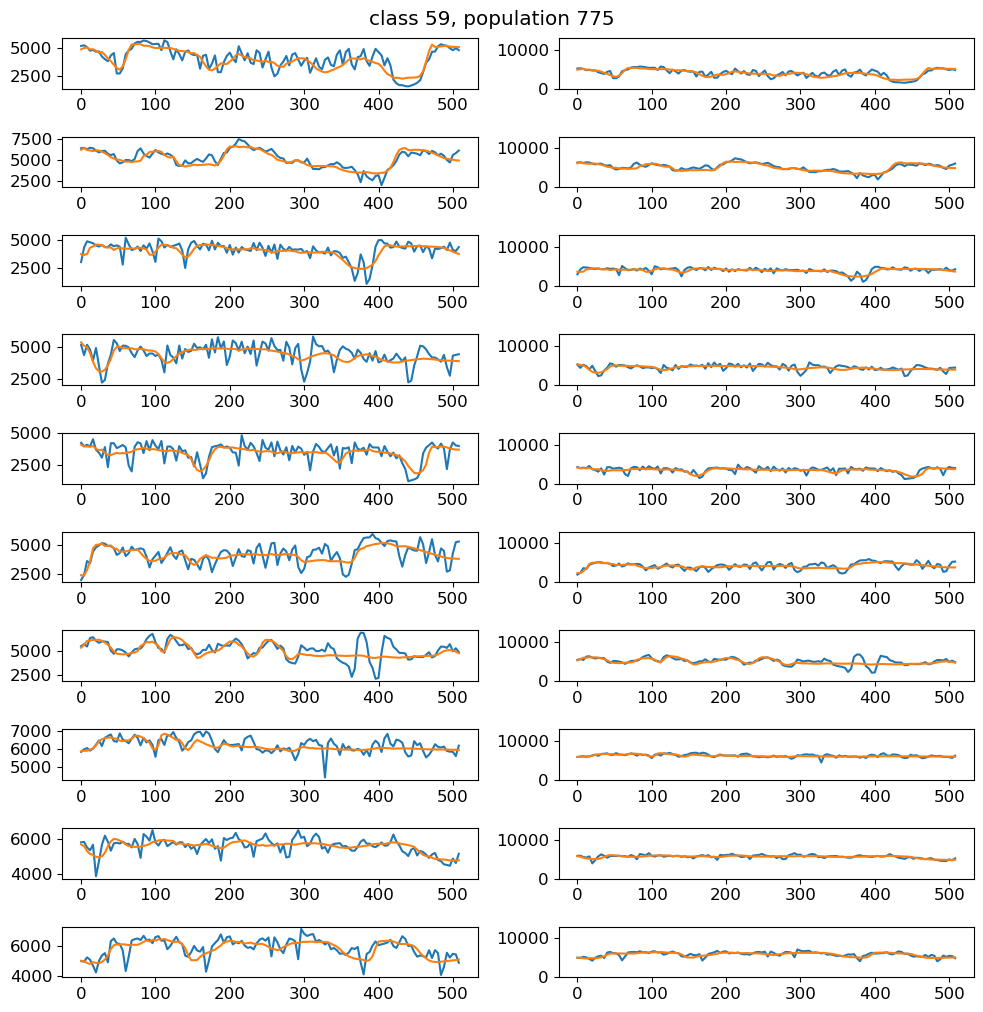

In [202]:
plt.close()

plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 12})

counts = np.unique(shape_moments_GM500_labels, return_counts=1)

# counts_todo = small_clusters[12] #merger_state["merger 347"]['cluster 829'][:2]
counts_todo = merger_state["merger 347"]['cluster 821'][:10]


how_many_to_plot = 10
for ind, new_class in enumerate(counts[0][np.argsort(counts[1])[::-1]]):
    if new_class not in counts_todo: continue
    class_segments = np.where(shape_moments_GM500_labels == new_class)[0]
    fig, axes = plt.subplots(nrows=how_many_to_plot, ncols=2)
    
    for subplot in range(how_many_to_plot):
        data = segments_counts[class_segments[subplot]]
        reconstruction = segment_reconstructions[class_segments[subplot]]
        axes[subplot, 0].plot(np.array(list(range(128)))*4,segments_counts[class_segments[subplot]])#, c="green", linewidth=0.5, zorder=-5)
        axes[subplot, 0].plot(np.array(list(range(128)))*4, reconstruction*np.std(data)+np.mean(data))
        axes[subplot, 1].plot(np.array(list(range(128)))*4,segments_counts[class_segments[subplot]])
        axes[subplot, 1].plot(np.array(list(range(128)))*4, reconstruction*np.std(data)+np.mean(data))
        axes[subplot, 1].set_ylim([0, 13000])
    plt.suptitle("class {}, population {}".format(new_class, np.sort(counts[1])[::-1][ind]), y=1.01)
    plt.tight_layout()
    plt.show()


In [73]:
# make a 468202 list of classifications for the new clusters

import copy

no_comps =500

starting_components = list(range(no_comps)) 
merger_state = dict(("merger "+str(merger_no), dict()) for merger_no in list(range(no_comps)))
merger_state["merger 0"]=dict(("cluster "+str(component),[component]) for component in starting_components)
for merger_no, merger_comps in enumerate(merger_history):
    merger_state["merger "+str(merger_no+1)] = copy.deepcopy(merger_state["merger "+str(merger_no)])
    merged_components = copy.deepcopy([merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[0])], merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[1])]])
    del merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[0])]
    del merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_comps[1])]
    merger_state["merger "+str(merger_no+1)]["cluster "+str(merger_no+no_comps)] = [item for sublist in merged_components for item in sublist]

# component_datapoints = np.zeros(no_comps+len(merger_history))
# component_datapoints[:no_comps] = component_vol_members_density_df.members.values

# for merger_ind, merger in enumerate(merger_history):
#     merger_ind+=no_comps
#     component_datapoints[merger_ind] = component_datapoints[merger[0]]+component_datapoints[merger[1]]

# for merger_key,merger_vals in merger_state.items():
#     # count number of components that make up each cluster, then find how common the counts are
#     no_unique_component_counts = np.unique([len(comp_vals) for comp_key, comp_vals in merger_vals.items()], return_counts=True) 
#     comps_involved = [int(cluster_str[8:]) for cluster_str in merger_vals.keys()]
#     print(merger_key,"\tnumber of clusters: ", len(merger_vals),"\t sizes of clusters, number of each size of cluster", no_unique_component_counts, "\tmax cluster size: ",
#           np.max([component_datapoints[comp_ind] for comp_ind in comps_involved]))


no_mergers_to_perform = 347

composite_clusters = merger_state["merger {}".format(no_mergers_to_perform)]

new_classification = []

for label in shape_moments_GM500_labels:
    for cluster, components in composite_clusters.items():
        if label in components:
            new_classification.append(int(cluster.split(" ")[1]))
        
new_classification

[832,
 823,
 823,
 823,
 832,
 831,
 823,
 823,
 823,
 821,
 840,
 753,
 823,
 821,
 823,
 823,
 619,
 823,
 823,
 823,
 823,
 823,
 823,
 803,
 823,
 823,
 298,
 803,
 823,
 823,
 755,
 823,
 821,
 823,
 821,
 821,
 822,
 823,
 823,
 755,
 146,
 830,
 823,
 823,
 823,
 823,
 832,
 823,
 823,
 823,
 823,
 832,
 821,
 823,
 841,
 823,
 823,
 803,
 823,
 823,
 355,
 479,
 827,
 766,
 823,
 832,
 823,
 823,
 823,
 823,
 823,
 823,
 292,
 761,
 761,
 823,
 818,
 823,
 823,
 821,
 812,
 476,
 826,
 755,
 823,
 180,
 488,
 821,
 823,
 821,
 823,
 839,
 823,
 37,
 823,
 823,
 823,
 708,
 823,
 832,
 823,
 823,
 690,
 831,
 723,
 834,
 751,
 823,
 823,
 479,
 823,
 823,
 823,
 762,
 823,
 844,
 784,
 298,
 823,
 619,
 823,
 823,
 757,
 823,
 755,
 823,
 823,
 823,
 762,
 803,
 823,
 823,
 823,
 823,
 832,
 823,
 823,
 823,
 821,
 792,
 823,
 832,
 823,
 841,
 730,
 225,
 823,
 821,
 823,
 766,
 761,
 823,
 823,
 753,
 823,
 823,
 823,
 823,
 823,
 823,
 823,
 823,
 823,
 823,
 824,
 823,
 762,

# Compare clusters with Tomaso's classification

In [70]:
# load observation classifications from Huppenkothen 2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
        
# load IDs of segmented light curves: observationsID_segmentIndex
with open('{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

        
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [80]:
import pandas as pd

In [125]:
Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

comparison_matrix = np.zeros((len(np.unique(new_classification)), len(Belloni_classes)), dtype=int)

comparison_matrix_df = pd.DataFrame(comparison_matrix, columns=Belloni_classes, index=np.unique(new_classification))

for n_Bc, Belloni_class in enumerate(Belloni_classes):
    Belloni_class_indices = np.where(np.array(segment_class) == Belloni_class)[0]
    count_clusters_for_class = np.unique(np.take(new_classification, Belloni_class_indices), return_counts=True)
    for cluster_ind, cluster in enumerate(count_clusters_for_class[0]):
        comparison_matrix_df[Belloni_class][cluster] = count_clusters_for_class[1][cluster_ind]

In [100]:
normalized_comparison_matrix_df=(comparison_matrix_df-comparison_matrix_df.min())/(comparison_matrix_df.max()-comparison_matrix_df.min())

In [ ]:
comparison_matrix_df.

In [78]:
normalized_df=(df-df.min())/(df.max()-df.min())

array(['Unknown', 'Unknown', 'Unknown', ..., 'Unknown', 'Unknown',
       'Unknown'], dtype='<U7')

In [140]:
np.unique(new_classification, return_counts=True)[1]

array([   437,    587,    355,    314,    469,    238,    254,    392,
          191,    430,    280,    355,    506,    861,    356,    270,
          314,    471,    320,    303,    189,    155,    182,    397,
           85,    435,    360,    387,    232,    466,    375,    378,
          373,    405,    372,    142,   1056,    256,    275,    339,
          342,    577,    242,    261,    256,    344,    485,    323,
          350,    995,    496,    302,    223,    406,    203,    137,
          854,    787,    270,    296,    582,    602,    199,    565,
          704,    641,    389,    407,    426,    463,    296,    479,
          412,    360,    189,    267,    290,    597,    181,    270,
          469,    733,    428,    387,    168,    251,    404,    417,
          359,     59,    649,    211,    278,    286,    182,    484,
          299,    571,    381,    396,    455,    135,    817,   1568,
          907,   1131,   1231,   4243,   1817,   1472,   1028,   1097,
      

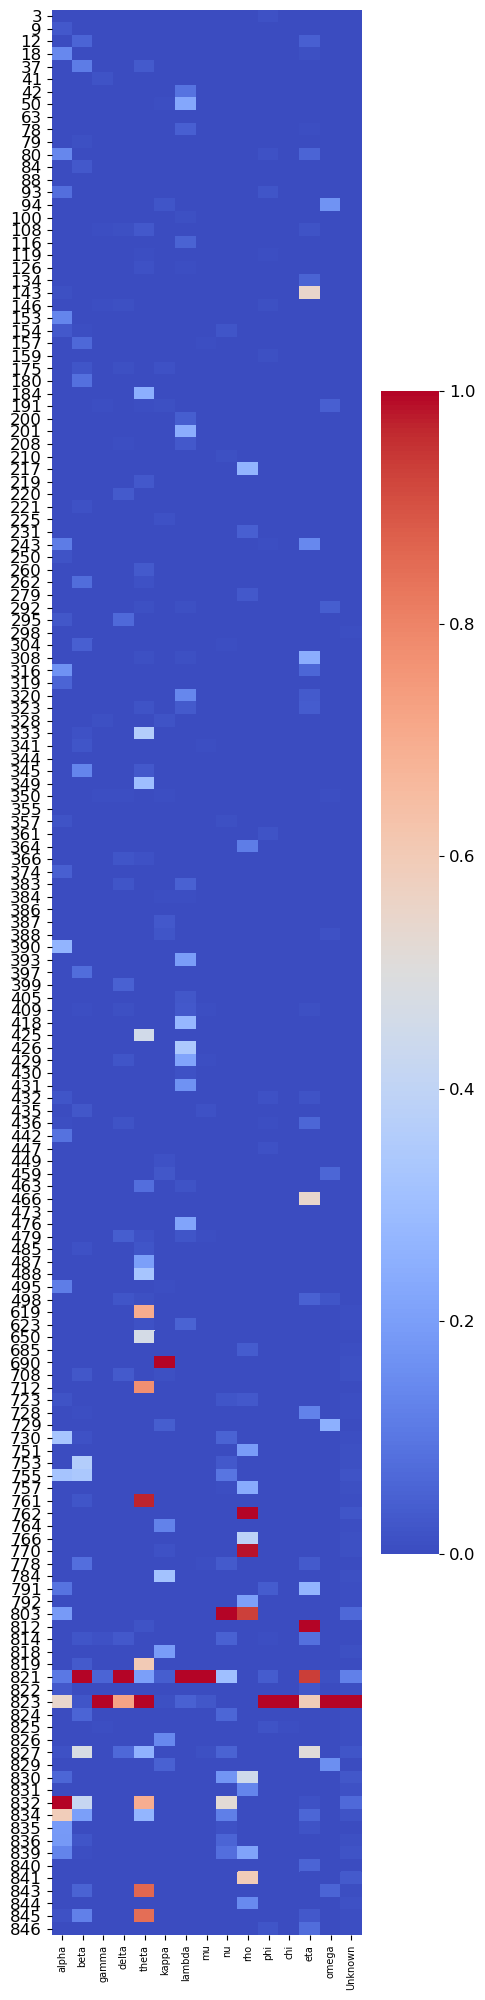

In [136]:
plt.rcParams['figure.figsize'] = (5.0, 25.0)


ax = sns.heatmap(normalized_comparison_matrix_df, xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)
plt.show()